In [33]:
# !pip install SimpleITK

In [34]:
import xml.etree.ElementTree as ET
import pandas as pd
from pathlib import Path
from statistics import median
from tqdm import tqdm
from collections import defaultdict

In [35]:
LIDC_PATH = Path(r"../dataset/LIDC-IDRI")
META_PATH = Path(r"../metadata/metadata.csv")

In [36]:
def extract_textures(xml_root):
    
    textures = defaultdict(list)

    for xml_file in tqdm(list(xml_root.rglob("*.xml")), desc="Parsing XMLs"):
        try:
            tree = ET.parse(str(xml_file))
            root = tree.getroot()

            # Strip XML namespace if present
            for elem in root.iter():
                if '}' in elem.tag:
                    elem.tag = elem.tag.split('}', 1)[1]

            # Flexible UID extraction
            uid_candidates = [
                root.find(".//SeriesInstanceUID"),
                root.find(".//SeriesInstanceUid"),
                root.find(".//CTSeriesInstanceUid"),
                root.find(".//CTSeriesInstanceUID"),
            ]
            suid = None
            for cand in uid_candidates:
                if cand is not None and cand.text:
                    suid = cand.text.strip()
                    break
            if not suid:
                continue

            # Flexible nodule iteration
            for nodule in root.findall(".//unblindedReadNodule") + root.findall(".//unblindedRead"):
                tex = nodule.find(".//texture")
                internal = nodule.find(".//internalStructure")
                val = None
                if tex is not None and tex.text and tex.text.strip().isdigit():
                    val = int(tex.text.strip())
                elif internal is not None and internal.text and internal.text.strip().isdigit():
                    val = int(internal.text.strip())
                if val is not None:
                    textures[suid].append(val)

        except Exception as e:
            print(f"{xml_file.name}: {e}")

    # Summarise per UID
    return {uid: int(round(median(vals))) for uid, vals in textures.items() if vals}


def texture_to_label(code):
    mapping = {1: "ground-glass", 2: "part-solid", 3:"solid"}
    return mapping.get(code, None)

In [37]:
print("Extracting texture info from LIDC XMLs...")
texture_map = extract_textures(LIDC_PATH)
df = pd.read_csv(META_PATH)
df["texture_code"] = df["uid"].map(texture_map)
df["texture_class"] = df["texture_code"].map(texture_to_label)

Extracting texture info from LIDC XMLs...


Parsing XMLs: 100%|██████████| 1180/1180 [00:13<00:00, 85.33it/s] 


In [38]:
df['texture_class'].value_counts()

texture_class
part-solid      27
ground-glass    23
solid           22
Name: count, dtype: int64

In [39]:
df

,uid,image,mask,diameter_mm,texture_code,texture_class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.651471,5.0,None
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.224708,5.0,None
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.786348,5.0,None
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,8.143262,5.0,None
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,18.545150,5.0,None
...,...,...,...,...,...,...
1180,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,5.053694,5.0,None
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.556101,5.0,None
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.357368,5.0,None
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,C:\Documents\fleishner_project\data\preprocess...,C:\Documents\fleishner_project\data\preprocess...,4.277203,5.0,None


## Extending Fleishner 3 Class Using HU

In [40]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

# HU  + Masked Texture Class

In [41]:

# Save as refine_texture_by_mask.py and run in your venv
import pandas as pd
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from tqdm import tqdm

META_OUT = Path(r"../metadata/metadata_with_3_class_textures.csv")

def infer_texture_masked(image_path, diameter_mm):
    """Read patch (already normalized to [0,1]) -> convert back to HU -> compute mask stats."""
    if not isinstance(image_path, str) or not Path(image_path).exists():
        return None  # will be handled upstream

    try:
        img = sitk.ReadImage(str(image_path))
        arr = sitk.GetArrayFromImage(img).astype(np.float32)  # shape z,y,x
        spacing = img.GetSpacing()  # (x,y,z) in SimpleITK
        # convert to HU if patches were normalized: arr_norm = (HU + 1000)/1400
        # If your patches were NOT normalized during saving, skip this revert.
        # We'll test heuristically: if arr.max() <= 1.1 assume normalized, else assume HU already.
        if arr.max() <= 1.1:
            hu = arr * 1400.0 - 1000.0
        else:
            hu = arr  # already in HU

        # center of patch assumed to be geometric center
        nz, ny, nx = hu.shape
        cz, cy, cx = (nz/2.0, ny/2.0, nx/2.0)

        # radius in voxels
        # spacing is (x, y, z) -> convert to (z,y,x)
        sx, sy, sz = spacing
        
        # voxel size for radius: use isotropic approx? use per-axis mapping for distance.
        # We'll create a spherical mask using real-world distances.
        radius_mm = float(diameter_mm) / 2.0
        # build coordinate grids in mm relative to center
        zz = (np.arange(nz) - cz) * sz
        yy = (np.arange(ny) - cy) * sy
        xx = (np.arange(nx) - cx) * sx
        Z, Y, X = np.meshgrid(zz, yy, xx, indexing='ij')  # shape (z,y,x)
        dist = np.sqrt((X**2) + (Y**2) + (Z**2))
        mask = dist <= radius_mm

        # compute stats inside mask
        masked_voxels = hu[mask]
        if masked_voxels.size == 0:
            return None
        median_hu = float(np.median(masked_voxels))
        p90 = float(np.percentile(masked_voxels, 90))
        frac_above_minus50 = float((masked_voxels > -50).sum()) / masked_voxels.size
        frac_above_minus300 = float((masked_voxels > -300).sum()) / masked_voxels.size

        return {
            "median_hu": median_hu,
            "p90_hu": p90,
            "frac_above_-50": frac_above_minus50,
            "frac_above_-300": frac_above_minus300
        }
    except Exception as e:
        print("Error reading", image_path, e)
        return None

def map_texture_from_stats(stats):
    if stats is None:
        return None
    median_hu = stats["median_hu"]
    p90 = stats["p90_hu"]
    fa50 = stats["frac_above_-50"]
    fa300 = stats["frac_above_-300"]

    # rule set (conservative)
    if p90 > -50 or (median_hu > -50 and fa50 > 0.15):
        return "solid"
    if median_hu > -300 or fa300 > 0.2:
        return "part-solid"
    return "ground-glass"

results = []

need_mask_infer = df[df['texture_class'].isna()]

for idx, row in tqdm(need_mask_infer.iterrows(), total=len(need_mask_infer['image'])):
    img_path = row['image']
    diameter = row['diameter_mm']
    stats = infer_texture_masked(img_path, diameter)
    texture = map_texture_from_stats(stats)
    results.append((idx, texture, stats))

for idx, texture, stats in results:
    df.at[idx, 'texture_class'] = texture
    if stats is not None:
        df.at[idx, 'median_hu'] = stats['median_hu']
        df.at[idx, 'p90_hu'] = stats['p90_hu']
        df.at[idx, 'frac_above_-50'] = stats['frac_above_-50']
        df.at[idx, 'frac_above_-300'] = stats['frac_above_-300']


df.to_csv(META_OUT, index=False)

print("Saved masked-inferred dataset to:", META_OUT)

100%|██████████| 1113/1113 [00:41<00:00, 26.58it/s]


Saved masked-inferred dataset to: ..\metadata\metadata_with_3_class_textures.csv


In [42]:
df['texture_class'].value_counts()

texture_class
solid           843
part-solid      194
ground-glass    148
Name: count, dtype: int64

<Axes: xlabel='texture_class'>

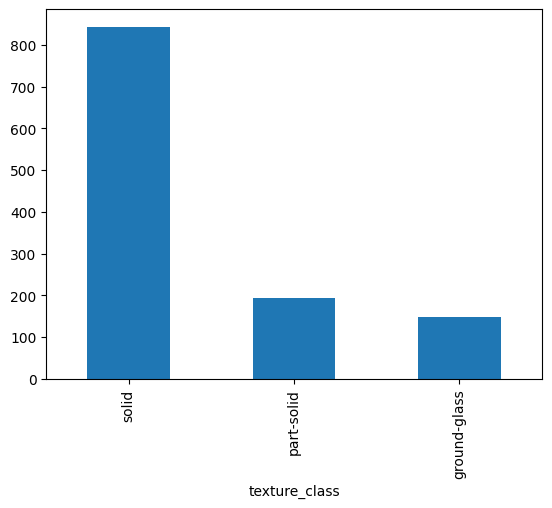

In [43]:
df['texture_class'].value_counts().plot(kind='bar')